# StockExplorer PixieApp Part 1
## We start by installing quandl and statsmodels library

In [ ]:
# !pip install quandl

In [ ]:
# !pip install statsmodels

## Import a few modules and optionally set the quandl API key

In [26]:
import pixiedust
from pixiedust.display.app import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quandl

#Comment the line below if you don't have a Quandl API Key
#To get an API key, go to https://www.quandl.com
quandl.ApiConfig.api_key = "XXXX"

## Download the list of database codes and display it using PixieDust display()

In [37]:
import requests
databases = []
page = 1
while(page is not None):
    payload = requests.get("https://www.quandl.com/api/v3/databases?api_key={}&page={}"\
                    .format(quandl.ApiConfig.api_key, page)).json()
    databases += payload['databases']
    page = payload['meta']['next_page']

In [38]:
display(databases)

database_code,datasets_count,description,downloads,favorite,id,image,name,premium,url_name
RICI,4,"Composite, USD based, total return index, representing the value of a basket of commodities consumed in the global economy.",18645,False,14993,http://d360wc4uc6n3i9.cloudfront.net/images/default-avatar.png,Rogers International Commodity Indices,False,Rogers-International-Commodity-Indices
BOF,2621,The Banque de France is responsible for monetary policy through policies of the European System of Central Banks and providing data on key economic indictors.,1333112,False,192,https://quandl-production-data-upload.s3.amazonaws.com/uploads/source/profile_image/192/thumb_bank-of-france.jpg,Bank of France,False,Bank-of-France
EUREX,2775,"Index, rate, agriculture and energy futures from EUREX, Europe's largest futures exchange, with history spanning a decade for select futures.",15631215,False,1280,https://quandl-production-data-upload.s3.amazonaws.com/uploads/source/profile_image/1280/thumb_thumb_eurexchange-346x194-auf-white.jpg,EUREX Futures Data,False,EUREX-Futures-Data
KRX,31,This database represents futures data from the Korea Exchange.,15751,False,15169,http://d360wc4uc6n3i9.cloudfront.net/images/default-avatar.png,Korea Exchange,False,Korea-Exchange
UIFS,8947,"This database offers comprehensive data on international financial indicators, such as average earnings, bond yields, government revenues and expenditures.",3264180,False,13145,http://d360wc4uc6n3i9.cloudfront.net/images/default-avatar.png,United Nations International Financial Statistics,False,United-Nations-International-Financial-Statistics
XNSE,7586,"Professional-grade EOD stock prices, dividends, adjustments and splits for all National Stock Exchange of India (NSE) stocks. Updated daily. History to 2007. Data from Exchange Data International.",26391613,False,15082,https://quandl-production-data-upload.s3.amazonaws.com/uploads/source/profile_image/15082/thumb_edi.png,National Stock Exchange of India Prices,True,National-Stock-Exchange-of-India-Prices
SF0,126944,"Free US fundamentals: 7 years of annual history for 7,500+ companies. Enter referral code at checkout for 100% off: VINPAV-100P-HWNT_SF0",1643264479,False,15119,https://quandl-production-data-upload.s3.amazonaws.com/uploads/source/profile_image/15119/thumb_thumb_sharadar-logo.jpg,Free US Fundamentals Data,True,Free-US-Fundamentals-Data
WGEN,6012,"Data describing gender differences in earnings, types of jobs, sectors of work, farmer productivity, and entrepreneurs’ firm sizes and profits.",3099859,False,13549,https://quandl-production-data-upload.s3.amazonaws.com/uploads/source/profile_image/13549/thumb_icon.jpg,World Bank Gender Statistics,False,World-Bank-Gender-Statistics
TAIFEX,1643,"Index and bond futures from TAIFEX, with history spanning over a decade for select futures.",1437733,False,15105,http://d360wc4uc6n3i9.cloudfront.net/images/default-avatar.png,Taiwan Futures Exchange,False,Taiwan-Futures-Exchange
NCDEX,7736,A professionally managed on-line multi-commodity exchange in India,1598049,False,15194,http://d360wc4uc6n3i9.cloudfront.net/images/default-avatar.png,National Commodity & Derivatives Exchange Limited (India),False,National-Commodity-Derivatives-Exchange-Limited-India


## Once you found the database_code, download the list of datasets associated with it
Note: we use below the WIKI dataset that provides US Stock data which surprisingly is not in the list of database codes from the above cell 

In [39]:
codes = pixiedust.sampleData("https://www.quandl.com/api/v3/databases/WIKI/codes?api_key=" + quandl.ApiConfig.api_key)
display(codes)

WIKI/AAPL,"Apple Inc (AAPL) Prices, Dividends, Splits and Trading Volume"
WIKI/OHI,"Omega Healthcare Investors Inc. (OHI) Prices, Dividends, Splits and Trading Volume"
WIKI/CMS,"CMS Energy Corp (CMS) Prices, Dividends, Splits and Trading Volume"
WIKI/UBA,"Urstadt Biddle Properties Inc. Cl A (UBA) Prices, Dividends, Splits and Trading Volume"
WIKI/MRIN,"Marin Software Inc (MRIN) Prices, Dividends, Splits and Trading Volume"
WIKI/DXPE,"DXP Enterprises Inc. (DXPE) Prices, Dividends, Splits and Trading Volume"
WIKI/ZBH,"Zimmer Biomet Holdings Inc (ZBH) Prices, Dividends, Splits and Trading Volume"
WIKI/RGS,"Regis Corp. (RGS) Prices, Dividends, Splits and Trading Volume"
WIKI/AVD,"American Vanguard (AVD) Prices, Dividends, Splits and Trading Volume"
WIKI/AN,"AutoNation Inc. (AN) Prices, Dividends, Splits and Trading Volume"
WIKI/NLS,"Nautilus (NLS) Prices, Dividends, Splits and Trading Volume"


## Download the stock data for MSFT and display a bokeh line chart of the Time Serie

In [27]:
msft = quandl.get('WIKI/MSFT')
msft['daily_spread'] = msft['Adj. Close'].diff()
msft = msft.reset_index()

In [93]:
display(msft)

## Display the daily spread for each day of the period

In [100]:
display(msft)

## Display growth of a hypothetical investment in the selected stock with initial value of $10,000

In [99]:
tail = msft[msft['Date'] > '2016-05-16']
investment = np.cumsum((10000 / tail['Adj. Close'].values[0]) * tail['daily_spread']) + 10000
investment = investment.astype(int)
investment.index = tail['Date']
investment = investment.resample('M').mean()
investment = pd.DataFrame(investment).reset_index()
display(investment)

## Start exploring the statistical properties of the MSFT time serie by looking at the moving average to detect trends and seasonality
Experiment with different window size

In [28]:
ma = msft['Adj. Close'].rolling(window=100).mean()
ma_df = pd.DataFrame(ma)
ma_df["x"] = ma_df.index
display(ma_df)

## Display the Auto-Correlation Function (ACF) and Partial Auto-correlation Function (PACF) of the MSFT Time serie

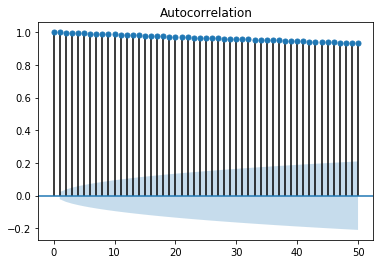

In [131]:
import statsmodels.tsa.api as smt
smt.graphics.plot_acf(msft['Adj. Close'], lags=50)
plt.show()

## ACF with lags = 1000

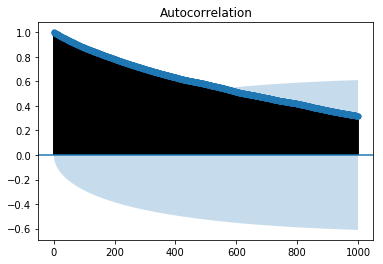

In [29]:
import statsmodels.tsa.api as smt
smt.graphics.plot_acf(msft['Adj. Close'], lags=1000)
plt.show()

## ACF chart with a periodic time series

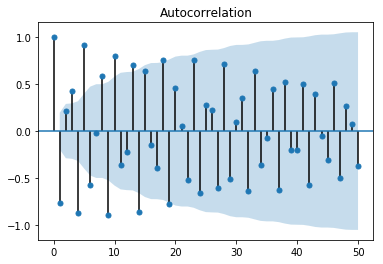

In [35]:
smt.graphics.plot_acf(np.cos(np.linspace(0, 1000, 100)), lags=50)
plt.show()

## Partial Autocorrelation (PACF) of the MSFT stock time series

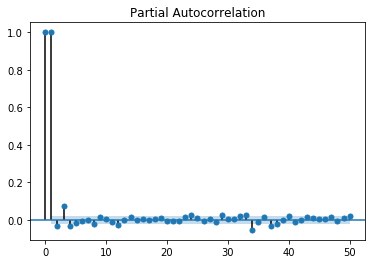

In [33]:
import statsmodels.tsa.api as smt
smt.graphics.plot_pacf(msft['Adj. Close'], lags=50)
plt.show()

## Build the first version of the StockExplorer PixieApp with the following capabilities
1. Enable the user to enter a list of Stock Tickers
2. Provide a menu for basic plotting: Price over time and Daily stock spread over time
3. Menu for displaying moving average with configurable lag
4. Menu for displaying ACF and PACF with configurable lag

## Base PixieApp used as parent class for all the subapp associated with each menu

In [ ]:
@PixieApp
class BaseSubApp():
    def setup(self):
        self.lag = 50

    def add_ticker_selection_markup(refresh_ids):
        def deco(fn):
            def wrap(self, *args, **kwargs):
                return """
<div class="row" style="text-align:center">
    <div class="btn-group btn-group-toggle" style="border-bottom:2px solid #eeeeee" data-toggle="buttons">
        {%for ticker, state in this.parent_pixieapp.tickers.items()%}
        <label class="btn btn-secondary {%if this.parent_pixieapp.active_ticker == ticker%}active{%endif%}"
            pd_refresh=\"""" + ",".join(refresh_ids) + """\" pd_script="self.parent_pixieapp.set_active_ticker('{{ticker}}')">
            <input type="radio" {%if this.parent_pixieapp.active_ticker == ticker%}checked{%endif%}> 
                {{ticker}}
        </label>
        {%endfor%}
    </div>
</div>
                """ + fn(self, *args, **kwargs)
            return wrap
        return deco
    
    @route(widget="lag_slider")
    def slider_screen(self):
        return """
<div>
    <label class="field">Lag:<span id="slideval{{prefix}}">50</span></label>
    <i class="fa fa-info-circle" style="color:orange" data-toggle="pd-tooltip" 
        title="Selected lag used to compute moving average, ACF or PACF"></i>
    <div id="slider{{prefix}}" name="slider" data-min=30 data-max=300
        data-default=50 style="margin: 0 0.6em;">
    </div>
</div>
<script>
$("[id^=slider][id$={{prefix}}]").each(function() {
    var sliderElt = $(this)
    var min = sliderElt.data("min")
    var max = sliderElt.data("max")
    var val = sliderElt.data("default")
    sliderElt.slider({
        min: isNaN(min) ? 0 : min,
        max: isNaN(max) ? 100 : max,
        value: isNaN(val) ? 50 : val,
        change: function(evt, ui) {
            $("[id=slideval{{prefix}}]").text(ui.value); 
            pixiedust.sendEvent({type:'lagSlider',value:ui.value})
        },
        slide: function(evt, ui) {
            $("[id=slideval{{prefix}}]").text(ui.value);
        }
    });
})
</script>
        """

## Sub App for basic exploration of the selected Stock Time Serie

In [ ]:
@PixieApp
class StockExploreSubApp(BaseSubApp):
    @route()
    @BaseSubApp.add_ticker_selection_markup(['chart{{prefix}}', 'daily_spread{{prefix}}'])
    def main_screen(self):
        return """
<div class="row" style="min-height:300px">
    <div class="col-xs-6" id="chart{{prefix}}" pd_render_onload pd_options="show_chart=Adj. Close">
    </div>
    <div class="col-xs-6" id="daily_spread{{prefix}}" pd_render_onload pd_options="show_chart=daily_spread">
    </div>
</div>
"""
        
    @route(show_chart="*")
    def show_chart_screen(self, show_chart):
        return """
<div pd_entity="parent_pixieapp.get_active_df()" pd_render_onload>
    <pd_options>
    {
      "handlerId": "lineChart",
      "valueFields": "{{show_chart}}",
      "rendererId": "bokeh",
      "keyFields": "Date",
      "noChartCache": "true",
      "rowCount": "10000"
    }
    </pd_options>
</div>
        """

## Sub App for displaying moving average of the selected Stock Time Serie

In [ ]:
@PixieApp
class MovingAverageSubApp(BaseSubApp):
    @route()
    @BaseSubApp.add_ticker_selection_markup(['chart{{prefix}}'])
    def main_screen(self):
        return """
<div class="row" style="min-height:300px">
    <div class="page-header text-center">
        <h1>Moving Average for {{this.parent_pixieapp.active_ticker}}</h1>
    </div>
    <div class="col-sm-12" id="chart{{prefix}}" pd_render_onload pd_entity="get_moving_average_df()">
        <pd_options>
        {
          "valueFields": "Adj. Close",
          "keyFields": "x",
          "rendererId": "bokeh",
          "handlerId": "lineChart",
          "rowCount": "10000"
        }
        </pd_options>
    </div>
</div>
<div class="row">
    <div pd_widget="lag_slider">
        <pd_event_handler 
            pd_source="lagSlider"
            pd_script="self.lag = eventInfo['value']"
            pd_refresh="chart{{prefix}}">
        </pd_event_handler>
    </div>
</div>
"""
    def get_moving_average_df(self):
        ma = self.parent_pixieapp.get_active_df()['Adj. Close'].rolling(window=self.lag).mean()
        ma_df = pd.DataFrame(ma)
        ma_df["x"] = ma_df.index
        return ma_df

## Sub App for displaying ACF and PACF of the selected Stock Time Serie

In [ ]:
import statsmodels.tsa.api as smt
@PixieApp
class AutoCorrelationSubApp(BaseSubApp):
    @route()
    @BaseSubApp.add_ticker_selection_markup(['chart_acf{{prefix}}', 'chart_pacf{{prefix}}'])
    def main_screen(self):
        return """
<div class="row" style="min-height:300px">
    <div class="col-sm-6">
        <div class="page-header text-center">
            <h1>Auto-correlation Function</h1>
        </div>
        <div id="chart_acf{{prefix}}" pd_render_onload pd_options="show_acf=true">
        </div>
    </div>
    <div class="col-sm-6">
        <div class="page-header text-center">
            <h1>Partial Auto-correlation Function</h1>
        </div>
        <div id="chart_pacf{{prefix}}" pd_render_onload pd_options="show_pacf=true">
        </div>
    </div>
</div> 

<div class="row">
    <div pd_widget="lag_slider">
        <pd_event_handler 
            pd_source="lagSlider"
            pd_script="self.lag = eventInfo['value']"
            pd_refresh="chart_acf{{prefix}},chart_pacf{{prefix}}">
        </pd_event_handler>
    </div>
</div>
"""
    @route(show_acf='*')
    @captureOutput
    def show_acf_screen(self):
        smt.graphics.plot_acf(self.parent_pixieapp.get_active_df()['Adj. Close'], lags=self.lag)
    
    @route(show_pacf='*')
    @captureOutput
    def show_pacf_screen(self):
        smt.graphics.plot_pacf(self.parent_pixieapp.get_active_df()['Adj. Close'], lags=self.lag)

## Main class for the StockExplorer PixieApp

In [ ]:
@PixieApp
class StockExplorer():
    @route()
    def main_screen(self):
        return """
<style>
    div.outer-wrapper {
        display: table;width:100%;height:300px;
    }
    div.inner-wrapper {
        display: table-cell;vertical-align: middle;height: 100%;width: 100%;
    }
</style>
<div class="outer-wrapper">
    <div class="inner-wrapper">
        <div class="col-sm-3"></div>
        <div class="input-group col-sm-6">
          <input id="stocks{{prefix}}" type="text" class="form-control" 
              value="MSFT,AMZN,IBM"
              placeholder="Enter a list of stocks separated by comma e.g MSFT,AMZN,IBM">
          <span class="input-group-btn">
            <button class="btn btn-default" type="button" pd_options="explore=true">
                <pd_script>
self.select_tickers('$val(stocks{{prefix}})'.split(','))
                </pd_script>
                Explore
            </button>
          </span>
        </div>
    </div>
</div>   
"""
    
    def select_tickers(self, tickers):
        self.tickers = {ticker.strip():{} for ticker in tickers}
        self.set_active_ticker(tickers[0].strip())
        
    def set_active_ticker(self, ticker):
        self.active_ticker = ticker
        if 'df' not in self.tickers[ticker]:
            self.tickers[ticker]['df'] = quandl.get('WIKI/{}'.format(ticker))
            self.tickers[ticker]['df']['daily_spread'] = self.tickers[ticker]['df']['Adj. Close'] - self.tickers[ticker]['df']['Adj. Open']
            self.tickers[ticker]['df'] = self.tickers[ticker]['df'].reset_index()
            
    def get_active_df(self):
        return self.tickers[self.active_ticker]['df']

    @route(explore="*")
    @templateArgs
    def stock_explore_screen(self):
        tabs = [("Explore","StockExploreSubApp"), ("Moving Average", "MovingAverageSubApp"),
                ("ACF and PACF", "AutoCorrelationSubApp")]
        return """
<style>    
    .btn:active, .btn.active {
        background-color:aliceblue;
    }
</style>
<div class="page-header">
  <h1>Stock Explorer PixieApp</h1>
</div>
<div class="container-fluid">
    <div class="row">
        <div class="btn-group-vertical btn-group-toggle col-sm-2" data-toggle="buttons">
            {%for title, subapp in tabs%}
            <label class="btn btn-secondary {%if loop.first%}active{%endif%}"
                pd_options="show_analytic={{subapp}}"
                pd_target="analytic_screen{{prefix}}">
                <input type="radio" {%if loop.first%}checked{%endif%}> 
                    {{title}}
            </label>
            {%endfor%}
        </div>
        <div id="analytic_screen{{prefix}}" class="col-sm-10">
        </div>
    </div>
"""
    @route(show_analytic="*")
    def show_analytic_screen(self, show_analytic):
        return """
<div pd_app="{{show_analytic}}" pd_render_onload></div>
"""
    
app = StockExplorer()
app.run()